Markov state model for penta peptide
=====


In [1]:
import pyemma
pyemma.__version__

u'1.2+458.g32596f8'

This notebook has been tested for version 1.2.1. If you are using a different version some adaptations may be required.

Now we import a few general packages, including basic numerics and algebra routines (numpy) and plotting routines (matplotlib), and makes sure that all plots are shown inside the notebook rather than in a separate window (nicer that way).

In [2]:
import os
%pylab inline
matplotlib.rcParams.update({'font.size': 12})

Populating the interactive namespace from numpy and matplotlib


Now we import the pyEMMA modules required later

In [3]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mpl
from pyemma import config

WW-pentapeptide - load data
------

We first have to load the PDB file and the trajectory data, in this case for WW-pentapeptide.

In [4]:
indir = './data'
topfile =  indir+'/init-ww-penta.pdb'
traj_list = []
for filename in os.listdir(indir):
    if filename.endswith('-protein.xtc'):
        traj_list.append(os.path.join(indir,filename))

We can decide here which coordinates we would like to use in the further analysis. In this case simply the cartesian coordinates.

In [5]:
feat = coor.featurizer(topfile)
feat.add_backbone_torsions(cossin=True)
feat.describe()

['COS(PHI 0 LEU 2 )',
 'SIN(PHI 0 LEU 2 )',
 'COS(PHI 0 ALA 3 )',
 'SIN(PHI 0 ALA 3 )',
 'COS(PHI 0 LEU 4 )',
 'SIN(PHI 0 LEU 4 )',
 'COS(PHI 0 LEU 5 )',
 'SIN(PHI 0 LEU 5 )',
 'COS(PHI 0 TRP 1 )',
 'SIN(PHI 0 TRP 1 )',
 'COS(PHI 0 LEU 2 )',
 'SIN(PHI 0 LEU 2 )',
 'COS(PHI 0 ALA 3 )',
 'SIN(PHI 0 ALA 3 )',
 'COS(PHI 0 LEU 4 )',
 'SIN(PHI 0 LEU 4 )']

Now we load the coordinates and check the number of dimensions:

In [6]:
inp = coor.source(traj_list, feat)
print 'number of trajectories = ',inp.number_of_trajectories()
print 'trajectory length = ',inp.trajectory_length(0)
print 'number of dimension = ',inp.dimension()

number of trajectories =  25
trajectory length =  5001
number of dimension =  16


#TICA and clustering 

In [7]:
tica_lag = 15      # tica lagtime
# FN: Dimension is no longer needed, because we have automatic selection below

In [8]:
# FN: do TICA with 95% kinetic variance
tica_obj = coor.tica(inp, lag=tica_lag, kinetic_map=True, var_cutoff=0.95)#, dim=tica_dim)

2015-07-20 17:36:45,150 coordinates.transform.TICA[1] INFO     reset (previous) parametrization state, since data producer has been changed.
2015-07-20 17:36:45,151 coordinates.transform.TICA[1] INFO     Running TICA with tau=15; Estimating two covariance matrices with dimension (16, 16)


In [9]:
# Nice separation: we get 98.7% of the kinetic variance with three dimensions - the rest is irrelevant.
tica_obj.cumvar

array([ 0.3682124 ,  0.70986172,  0.91980948,  0.9940418 ,  0.99937093,
        0.99958574,  0.99971166,  0.99978673,  0.99985472,  0.99991333,
        0.99994787,  0.99997473,  0.99999129,  0.99999581,  0.99999825,  1.        ])

In [10]:
Y = tica_obj.get_output() # get tica coordinates

In [11]:
# three significant eigenvalues
tica_obj.eigenvalues

array([ 0.73324707,  0.70630358,  0.55367735,  0.32922868,  0.08821231,
        0.0177106 ,  0.01355954,  0.01046987, -0.0099636 , -0.00925054,
        0.00710229,  0.00626272, -0.00491622,  0.00257133, -0.00188574,
        0.00159912])

Now we look at the distribution on the two dominant TICA coordinates

/storage/mi/nplattner/miniconda/envs/PyE-devR/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log


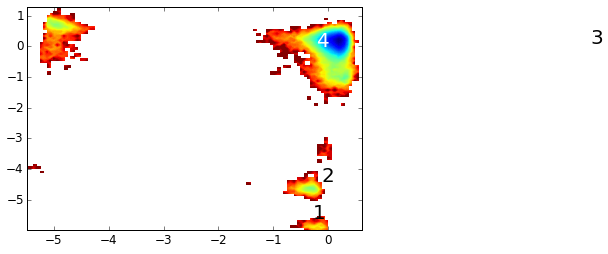

In [12]:
npY = np.array(Y)
npYc = np.concatenate(npY)
# histogram data
z,x,y = np.histogram2d(npYc[:,0],npYc[:,1], bins=100)
# compute free energies
F = -np.log(z)
# contour plot
extent = [x[0], x[-1], y[0], y[-1]]
contourf(F.T, 100, extent=extent)
text(-0.25, -5.6, '1', fontsize=20, color='black')
text(-0.1, -4.4, '2', fontsize=20, color='black')
text(4.8, 0.1, '3', fontsize=20, color='black')
text(-0.2, 0, '4', fontsize=20, color='white')
savefig('./figs/free_energy_count.png')

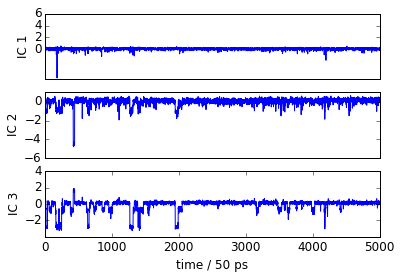

In [13]:
ax1=plt.subplot(311)
plot(Y[0][:,0]); ylabel('IC 1'); xticks([]); yticks([0,2,4,6])
ax1=plt.subplot(312)
plot(Y[0][:,1]); ylabel('IC 2'); xticks([]); yticks([-6, -4, -2, 0])
ax1=plt.subplot(313)
plot(Y[0][:,2]); xlabel('time / 50 ps'); ylabel('IC 3'); yticks([-2,0,2,4])
savefig('./figs/traj_ic.png')

In [14]:
n_clusters = 100      # number of k-means clusters
cl_metric = 'euclidean' # clustering metric

In [15]:
clustering = coor.cluster_kmeans(Y,k=n_clusters)

2015-07-20 17:36:55,028 coordinates.clustering.KmeansClustering[2] INFO     reset (previous) parametrization state, since data producer has been changed.
2015-07-20 17:36:56,090 coordinates.clustering.KmeansClustering[2] INFO     Accumulated all data, running kmeans on (125025, 4)
2015-07-20 17:36:57,013 coordinates.clustering.KmeansClustering[2] INFO     Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


In [16]:
dtrajs = coor.assign_to_centers(Y, centers=clustering.clustercenters, stride=1, return_dtrajs=True, metric=cl_metric)

2015-07-20 17:36:57,017 coordinates.clustering.AssignCenters[4] INFO     reset (previous) parametrization state, since data producer has been changed.


In order to analyze the distribution of the data to the cluster centers we make a histogram of the discrete trajectories.

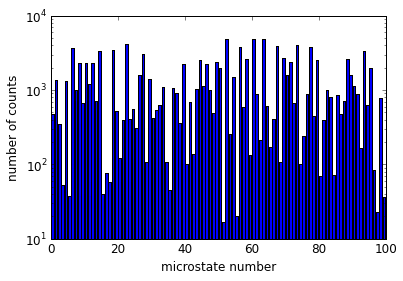

In [17]:
histogram = np.bincount(np.concatenate(dtrajs), minlength=len(clustering.clustercenters));
ind = np.arange(len(histogram))
plt.bar(ind, histogram, log=True)
plt.xlabel('microstate number')
plt.ylabel('number of counts')

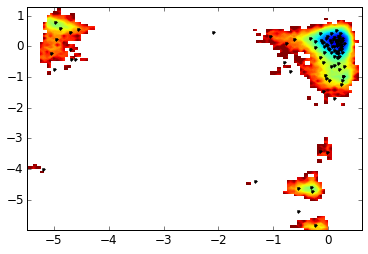

In [18]:
cc_x = clustering.clustercenters[:,0]
cc_y = clustering.clustercenters[:,1]
contourf(F.T, 100, extent=extent)
plot(cc_x,cc_y, linewidth=0, marker='.', color='black')

The states are well distributed in phase space.

#Implied timescales

In [19]:
its = msm.timescales_msm(dtrajs, lags=100, nits=5, errors='bayes')
#its = msm.timescales_msm(dtrajs, lags=100, nits=5)

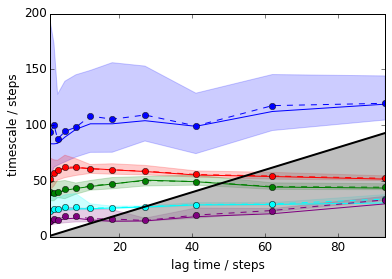

In [20]:
mpl.plot_implied_timescales(its, ylog=False)
ylim(0, 200)
savefig('./figs/its.png')

# Estimate MSM

In [21]:
M = msm.bayesian_markov_model(dtrajs, 20)
print 'fraction of states used = ', M.active_state_fraction
print 'fraction of counts used = ', M.active_count_fraction

fraction of states used =  1.0
fraction of counts used =  1.0


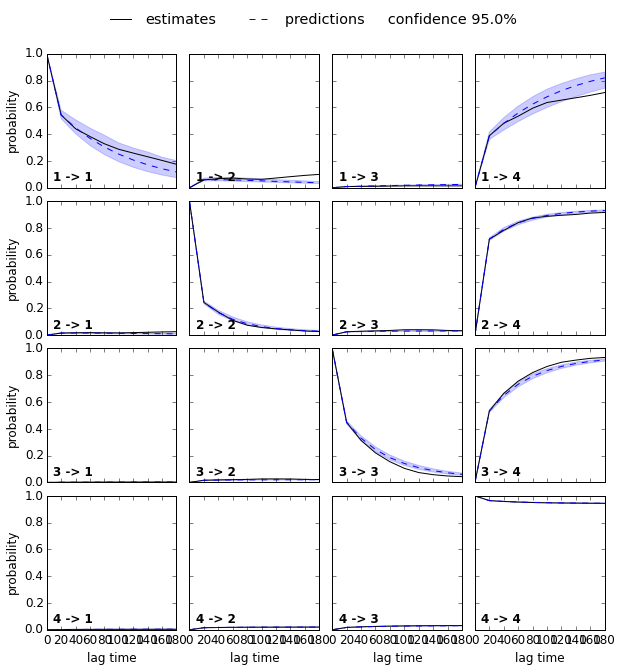

In [22]:
# validate
cktest = M.cktest(4)
mpl.plot_cktest(cktest);
savefig('./figs/cktest.png')

From the Markov state model which is now stored in the object we called *M* various properties can be obtained. We start by analyzing the stationary distribution.

In [23]:
pi = M.stationary_distribution # stationary distribution
F_pi = -np.log(pi)  # free energy based on stationary distribution

In [24]:
def mycontour(x, y, z, ncontours = 50, colorbar=True, fig=None, ax=None, method='linear', zlim=None, cmap=None, outfile=None):
    from scipy.interpolate import griddata as gd
    # check input
    if (ax is None):
        if fig is None:
            ax = plt.gca()
        else:
            ax = fig.gca()

    # grid data
    points = np.hstack([x[:,None],y[:,None]])
    xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
    zi = gd(points, z, (xi, yi), method=method)
    # contour level levels
    if zlim is None:
        zlim = (z.min(), z.max())
    eps = (zlim[1] - zlim[0]) / float(ncontours)
    levels = np.linspace(zlim[0] - eps, zlim[1] + eps)
    # contour plot
    if cmap is None:
        cmap=plt.cm.jet
    cf = ax.contourf(xi, yi, zi, ncontours, cmap=cmap, levels=levels)
    # color bar if requested
    if colorbar:
        plt.colorbar(cf, ax=ax)
    # scatter points
    # ax.scatter(x,y,marker='o',c='b',s=5)    
    return ax

In [25]:
xall = np.vstack(Y)[:,0]
yall = np.vstack(Y)[:,1]
W = np.concatenate(M.trajectory_weights())
# compute free energies
Fall = -np.log(W)
Fall -= np.min(Fall)

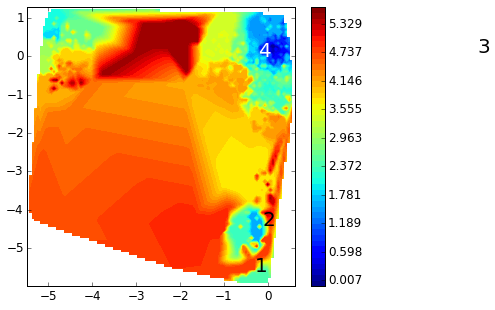

In [26]:
#fig = plt.figure(figsize=(16,5))
#matplotlib.rcParams.update({'font.size': 12})
#ax1=plt.subplot(121)
#ax1.set_title('Stationary distribution')
#mycontour(xall, yall, W)

fig = plt.figure(figsize=(6,5))
#ax2=plt.subplot(122)
#ax2.set_title('Free energy')
mycontour(xall, yall, Fall)
text(-0.25, -5.6, '1', fontsize=20, color='black')
text(-0.1, -4.4, '2', fontsize=20, color='black')
text(4.8, 0.1, '3', fontsize=20, color='black')
text(-0.2, 0, '4', fontsize=20, color='white')
savefig('./figs/free_energy_msm.png')

In [27]:
# project eigenvectors
proj_ev1_all = np.hstack([M.eigenvectors_right()[:,1][dtraj] for dtraj in M.discrete_trajectories_full])
proj_ev2_all = np.hstack([M.eigenvectors_right()[:,2][dtraj] for dtraj in M.discrete_trajectories_full])
proj_ev3_all = np.hstack([M.eigenvectors_right()[:,3][dtraj] for dtraj in M.discrete_trajectories_full])

Now we analyze the slowest processes by looking at the distribution of states along the first 3 eigenvectors.

In [28]:
def printlabels():
    text(-0.25, -5.6, '1', fontsize=20, color='white')
    text(-0.1, -4.4, '2', fontsize=20, color='white')
    text(4.8, 0.1, '3', fontsize=20, color='white')
    text(-0.2, 0, '4', fontsize=20, color='white')

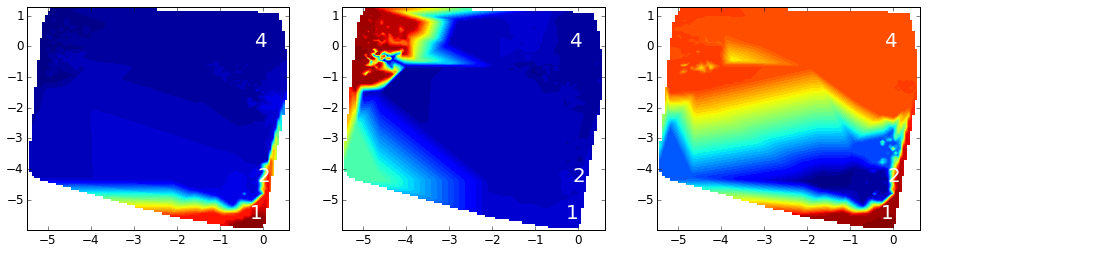

In [29]:
fig = plt.figure(figsize=(16,4))

ax1=plt.subplot(131)
r2 = M.eigenvectors_right()[:,1]
ax1 = mycontour(xall, yall, proj_ev1_all, method='linear', colorbar=False)
printlabels()

ax2=plt.subplot(132)
r3 = M.eigenvectors_right()[:,2]
ax2 = mycontour(xall, yall, proj_ev2_all, method='linear', colorbar=False)
printlabels()

ax3=plt.subplot(133)
r4 = M.eigenvectors_right()[:,3]
ax3 = mycontour(xall, yall, -proj_ev3_all, method='linear', colorbar=False)
printlabels()
savefig('./figs/eigenvectors.png')

Next the MSM is coarse grained into a user-defined number of macrostates (*n_sets*).

In [30]:
n_sets = 4
M.pcca(n_sets)
pcca_dist = M.metastable_distributions
membership=M.metastable_memberships  # get PCCA memberships
# memberships over trajectory
mem1_all = np.hstack([membership[:,0][dtraj] for dtraj in M.discrete_trajectories_full])
mem2_all = np.hstack([membership[:,1][dtraj] for dtraj in M.discrete_trajectories_full])
mem3_all = np.hstack([membership[:,2][dtraj] for dtraj in M.discrete_trajectories_full])
mem4_all = np.hstack([membership[:,3][dtraj] for dtraj in M.discrete_trajectories_full])

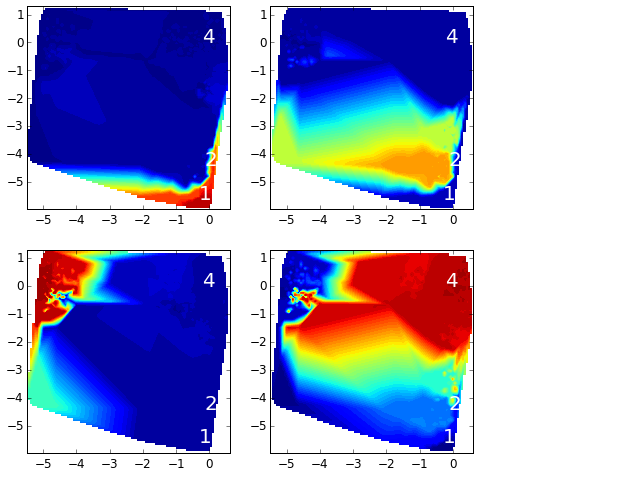

In [31]:
fig = plt.figure(figsize=(8,8))

ax1 = plt.subplot(221)
ax1 = mycontour(xall, yall, mem1_all, zlim=[0,1], method='linear', colorbar=False)
printlabels()

ax2 = plt.subplot(222)
ax2 = mycontour(xall, yall, mem2_all, zlim=[0,1], method='linear', colorbar=False)
printlabels()

ax3 = plt.subplot(223)
ax3 = mycontour(xall, yall, mem3_all, zlim=[0,1], method='linear', colorbar=False)
printlabels()

ax4 = plt.subplot(224)
ax4 = mycontour(xall, yall, mem4_all, zlim=[0,1], method='linear', colorbar=False)
printlabels()
savefig('./figs/pcca_dists.png')

In [32]:
pcca_samples = M.sample_by_distributions(pcca_dist, 10)

In [33]:
# you can do this in one command
coor.save_trajs(inp, pcca_samples, outfiles=['./data/pcca1_10samples.xtc','./data/pcca2_10samples.xtc',
                                             './data/pcca3_10samples.xtc','./data/pcca4_10samples.xtc'])

2015-07-20 17:39:48,235 coordinates.api INFO     Created file ./data/pcca1_10samples.xtc
2015-07-20 17:39:48,613 coordinates.api INFO     Created file ./data/pcca2_10samples.xtc
2015-07-20 17:39:49,018 coordinates.api INFO     Created file ./data/pcca3_10samples.xtc
2015-07-20 17:39:49,413 coordinates.api INFO     Created file ./data/pcca4_10samples.xtc


['./data/pcca1_10samples.xtc',
 './data/pcca2_10samples.xtc',
 './data/pcca3_10samples.xtc',
 './data/pcca4_10samples.xtc']

HMM
---

In [34]:
hmm = M.coarse_grain(4)

2015-07-20 17:39:49,418 MaximumLikelihoodHMSM[0x7fb34851d110] WARNING  Requested coarse-grained model with 4 metastable states at lag=20.The ratio of relaxation timescales between 4 and 5 states is only 1.83957701831 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.


In [35]:
hmm.eigenvalues()

array([ 1.        ,  0.75669267,  0.72677657,  0.52219659])

In [36]:
# mean cluster positions
pos = np.array([np.dot(M.metastable_distributions, cc_x), np.dot(M.metastable_distributions, cc_y)]).T
print pos

[[-0.18400532 -4.24486951]
 [-0.21791642 -2.16394131]
 [-3.0557828   0.28225126]
 [ 0.10572527  0.06406225]]


In [37]:
hmm.transition_matrix

array([[  5.75062223e-01,   6.64576110e-03,   4.96830162e-05,
          4.18242333e-01],
       [  4.18859719e-02,   7.60558160e-01,   5.15088451e-03,
          1.92404983e-01],
       [  2.55854285e-04,   4.20864876e-03,   7.31511937e-01,
          2.64023560e-01],
       [  5.14117443e-02,   3.75255265e-03,   6.30220160e-03,
          9.38533501e-01]])

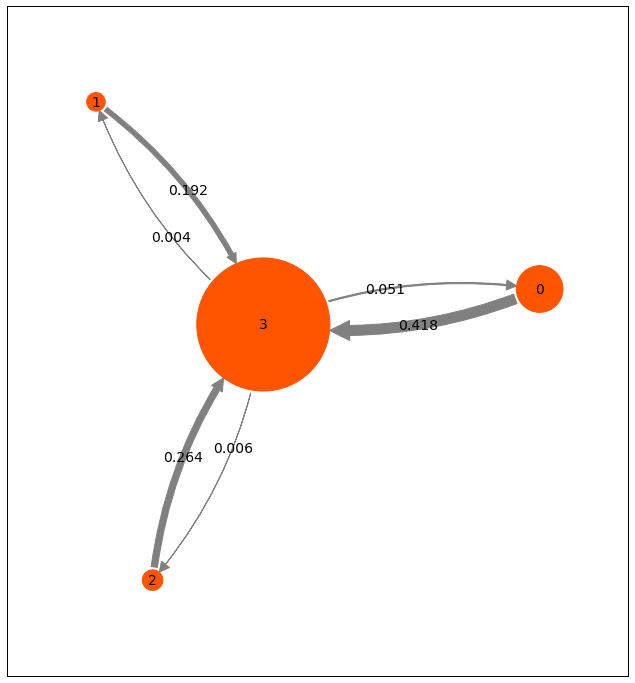

In [38]:
mpl.plot_markov_model(hmm, minflux=1e-03, arrow_label_format='%0.3f')
#mpl.plot_markov_model(hmm, pos=pos, minflux=1e-03)
#contourf(F.T, 100, extent=extent, zorder=0)
savefig('./figs/hmm_network.png')

In [39]:
membership=hmm.metastable_memberships  # get HMM memberships
# memberships over trajectory
mem1_all = np.hstack([membership[:,0][dtraj] for dtraj in M.discrete_trajectories_full])
mem2_all = np.hstack([membership[:,1][dtraj] for dtraj in M.discrete_trajectories_full])
mem3_all = np.hstack([membership[:,2][dtraj] for dtraj in M.discrete_trajectories_full])
mem4_all = np.hstack([membership[:,3][dtraj] for dtraj in M.discrete_trajectories_full])

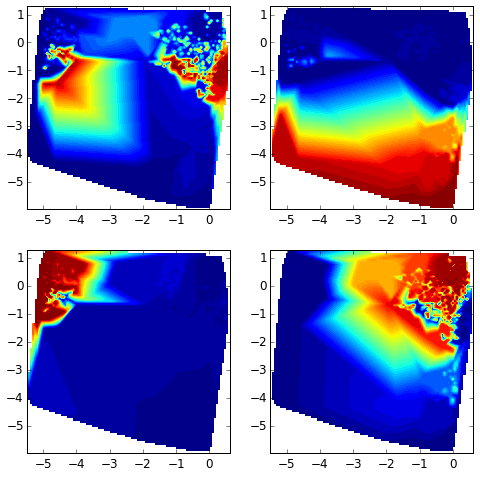

In [40]:
# FN: this looks weird. I need to check if this is converged.
# Or maybe something is wrong with the state assignment
fig = plt.figure(figsize=(8,8))

ax1 = plt.subplot(221)
ax1 = mycontour(xall, yall, mem1_all, zlim=[0,1], method='linear', colorbar=False)

ax2 = plt.subplot(222)
ax2 = mycontour(xall, yall, mem2_all, zlim=[0,1], method='linear', colorbar=False)

ax3 = plt.subplot(223)
ax3 = mycontour(xall, yall, mem3_all, zlim=[0,1], method='linear', colorbar=False)

ax4 = plt.subplot(224)
ax4 = mycontour(xall, yall, mem4_all, zlim=[0,1], method='linear', colorbar=False)